In [ ]:
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import quantum_info
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

import numpy as np
import matplotlib.pyplot as plt

### Quantum Teleportation

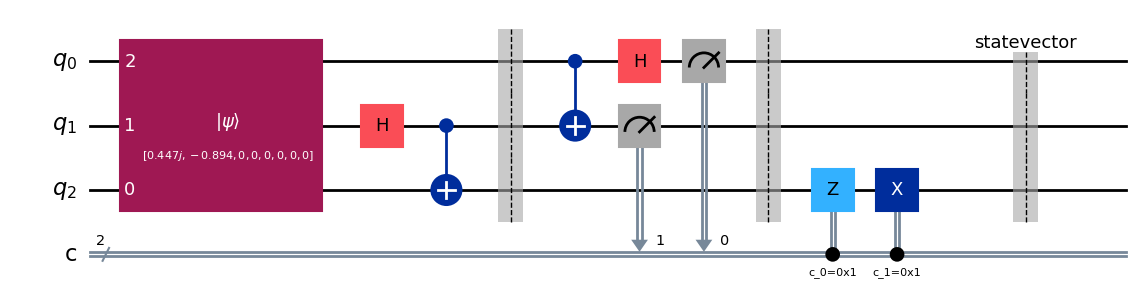

In [ ]:
circuit2 = QuantumCircuit(3, 2)

ket0 = quantum_info.Statevector(np.array([np.sqrt(0.2)*1j, -np.sqrt(0.8)]))
ket1 = quantum_info.Statevector([1, 0])
ket2 = quantum_info.Statevector([1, 0])
init_state = quantum_info.Statevector(ket2^ket1^ket0)

circuit2.initialize(init_state, [2,1,0])

circuit2.h(1)
circuit2.cx(1,2)
circuit2.barrier()

circuit2.cx(0,1)
circuit2.h(0)
circuit2.measure([0,1], [0,1])
circuit2.barrier()

circuit2.z(2).c_if(0, 1)
circuit2.x(2).c_if(1, 1)
circuit2.save_statevector()

circuit2.draw('mpl')

In [ ]:
init_state.draw('latex')

<IPython.core.display.Latex object>

In [ ]:
# final_state = init_state.evolve(circuit2)
# final_state.draw('latex')
sim_aer = AerSimulator()
job = sim_aer.run(circuit2, shots=1024)
result = job.result()
final_state = result.get_statevector()
final_state.draw('latex')

<IPython.core.display.Latex object>

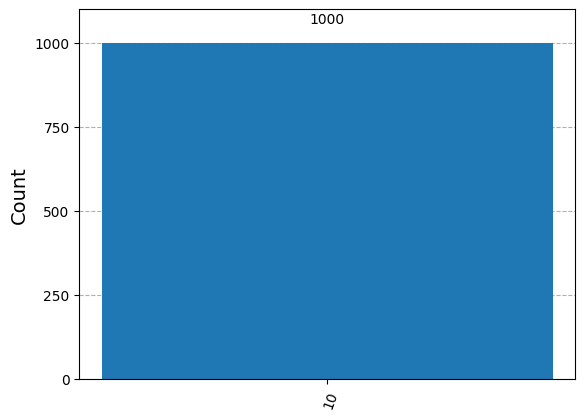

In [ ]:
aer_sim = AerSimulator()

swap_crt = transpile(swap_crt, backend=aer_sim)

sampler = Sampler(aer_sim)

result = sampler.run([swap_crt], shots=1000).result()

plot_histogram(result[0].data.c2.get_counts())

### Q3: Teleport Swap gates to distant qubits.

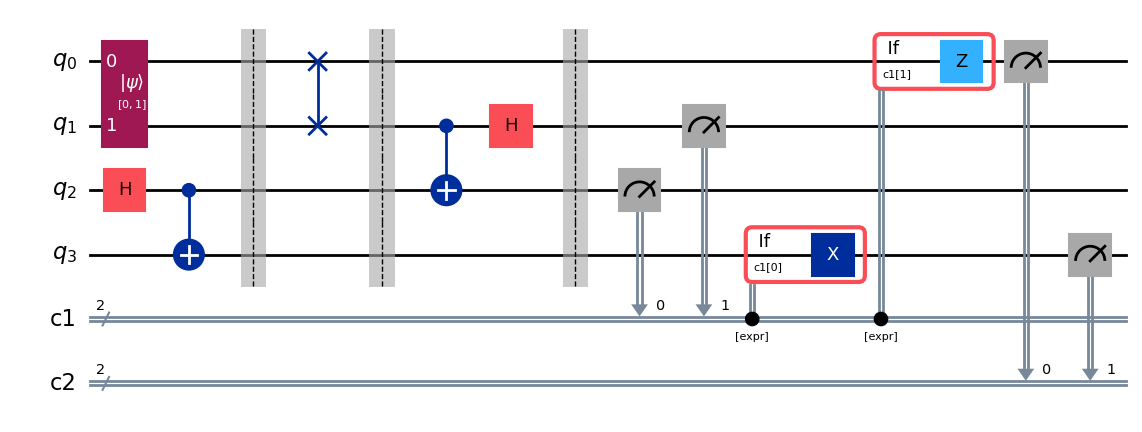

In [ ]:
q = QuantumRegister(4, name='q')
c1 = ClassicalRegister(2, name='c1')
c2 = ClassicalRegister(2, name='c2')
swap_crt = QuantumCircuit(q, c1, c2)

swap_crt.initialize('01', [0, 1])

# Bell state prep
swap_crt.h(2)
swap_crt.cx(2, 3)
swap_crt.barrier()

# swap_crt.h(0)
swap_crt.swap(0, 1)
swap_crt.barrier()

# Bell state measure
swap_crt.cx(1, 2)
swap_crt.h(1)

swap_crt.barrier()
swap_crt.measure([2, 1], [0, 1])

with swap_crt.if_test(expr.lift(c1[0])):
    swap_crt.x(3)

with swap_crt.if_test(expr.lift(c1[1])):
    swap_crt.z(0)

swap_crt.measure([0, 3], [2, 3])

swap_crt.draw('mpl')


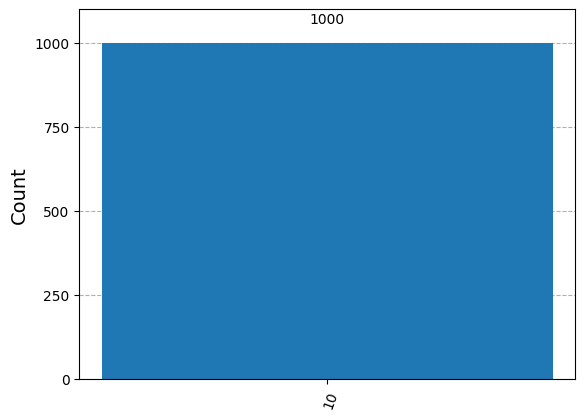

In [ ]:
aer_sim = AerSimulator()

swap_crt = transpile(swap_crt, backend=aer_sim)

sampler = Sampler(aer_sim)

result = sampler.run([swap_crt], shots=1000).result()

plot_histogram(result[0].data.c2.get_counts())

### Q5: Teleportation Circuit using Dynamic Circuits

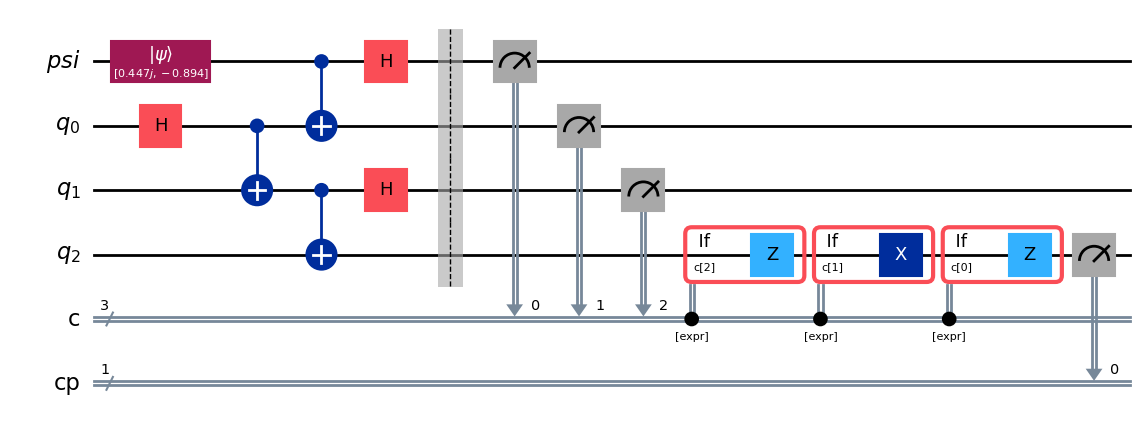

In [ ]:
input_psi = quantum_info.Statevector(np.sqrt(0.2)*np.array([1j, 0])) - quantum_info.Statevector(np.sqrt(0.8)*np.array([0, 1]))
# input_psi = quantum_info.Statevector(np.array([np.sqrt(0.2)*1j, np.sqrt(0.8)]))
input_psi.draw('latex')

def teleportation():
    psi_circuit = QuantumRegister(1, name='psi')
    q_circuit = QuantumRegister(3, name='q')
    cls = ClassicalRegister(3, name='c')
    cls_phi = ClassicalRegister(1, name='cp')

    circuit = QuantumCircuit(psi_circuit, q_circuit, cls, cls_phi)

    circuit.initialize(input_psi, 0)

    circuit.h(1)
    circuit.cx(1,2)

    circuit.cx([0, 2], [1, 3])
    # circuit.cx(2, 3)

    circuit.h([0, 2])
    circuit.barrier()
    circuit.measure([0, 1, 2], [0, 1, 2])

    with circuit.if_test(expr.lift(cls[2])):
        circuit.z(3)

    with circuit.if_test(expr.lift(cls[1])):
        circuit.x(3)

    with circuit.if_test(expr.lift(cls[0])):
        circuit.z(3)

    circuit.measure(3, 3)

    return circuit

telep_circuit = teleportation()
telep_circuit.draw('mpl')

Output state: sqrt(0.21)|0> + sqrt(0.79)|1>


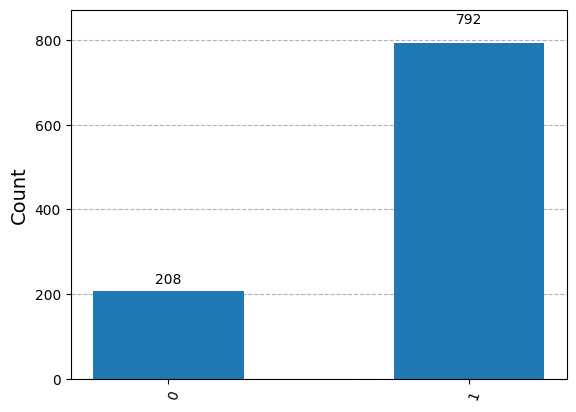

In [ ]:
aer_sim = AerSimulator()
telep_circuit = transpile(telep_circuit, backend=aer_sim)

sampler = Sampler(backend=aer_sim)

total_shots = 1000
result = sampler.run([telep_circuit], shots=total_shots).result()

stats = result[0].data.cp.get_counts()

prob_0 = stats['0']/total_shots
prob_1 = stats['1']/total_shots

print(f'Output state: sqrt({prob_0:.02f})|0> + sqrt({prob_1:.02f})|1>')

plot_histogram(stats)